In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import save_model

4.27930455107546
882.9033866694552


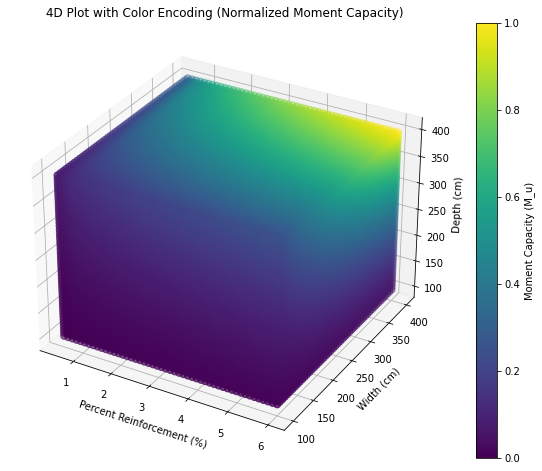

In [25]:
Design_space = np.load('Design_space.npy')
moment_capacity = np.load('Mu.npy')
p_values = Design_space[:, 0]
b_values = Design_space[:, 1]
d_values = Design_space[:, 2]


# Normalize moment capacity values to the range [0, 1]
min_output = np.min(moment_capacity)
max_output = np.max(moment_capacity)
normalized_outputs = (moment_capacity - min_output) / (max_output - min_output)

print(min_output)
print(max_output)

# Plot 4D data using color encoding
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Define color map
cmap = plt.get_cmap('viridis')

sc = ax.scatter(p_values, b_values, d_values, c=normalized_outputs, cmap=cmap, marker='o', s=50)
cbar = plt.colorbar(sc)
cbar.set_label('Moment Capacity (M_u)')

ax.set_xlabel('Percent Reinforcement (%)')
ax.set_ylabel('Width (cm)')
ax.set_zlabel('Depth (cm)')
ax.set_title('4D Plot with Color Encoding (Normalized Moment Capacity)')

plt.show()


In [18]:
# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(1,)),  # Input layer with 1 neuron
    Dense(32, activation='relu'),  # Hidden layer with 32 neurons
    Dense(3)  # Output layer with 3 neurons
])

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Using mean squared error loss and Adam optimizer

C:\Users\adelpasand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


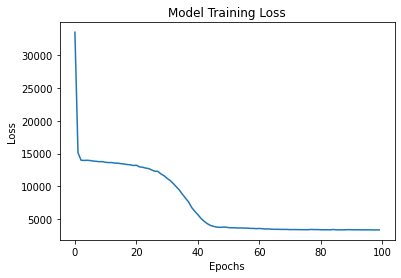

In [19]:
# Train the model
history = model.fit(moment_capacity, Design_space, epochs=100, batch_size=16, verbose=0)
model.save('trained_model.h5')
# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [54]:
from tensorflow.keras.models import load_model
model = load_model('trained_model.h5')

# picking 7 row from the data
step_size = Design_space.shape[0]//7

# selected actual design parameters associated with moment capacity .
selected_actual_params= Design_space[::step_size]
moment_capacity_test = moment_capacity[::step_size] # New input data for prediction
print(selected_actual_params)
print(moment_capacity_test)

# Predict on new data
moment_capacity_test = moment_capacity_test

Designe_pred = model.predict(moment_capacity_test)
print(Designe_pred)


# # Visualize results
# plt.figure(figsize=(15, 5))
# for i in range(3):
#     plt.subplot(1, 3, i+1)
#     plt.scatter(moment_capacity_test, outputs_pred[:, i], label='Predicted', color='red')
#     plt.plot(moment_capacity, outputs[:, i], label='True', color='blue')
#     plt.title(f'Output {i+1}')
#     plt.xlabel('MomentCapacity')
# plt.ylabel(['Width', 'Height', 'Reinforcement Ratio'][i])
# plt.legend()
# plt.tight_layout()
# plt.show()


[[  0.5        100.         100.        ]
 [  1.28571429 142.85714286 142.85714286]
 [  2.07142857 185.71428571 185.71428571]
 [  2.85714286 228.57142857 228.57142857]
 [  3.64285714 271.42857143 271.42857143]
 [  4.42857143 314.28571429 314.28571429]
 [  5.21428571 357.14285714 357.14285714]
 [  6.         400.         400.        ]]
[  4.27930455  24.27607822  63.46744868 131.9612675  238.77604918
 393.19274125 604.69100877 882.90338667]
1/1 [==============================] - 0s 66ms/step
[[  1.2554781 177.67009    92.94089  ]
 [  1.9709284 205.59981   127.24578  ]
 [  2.345297  223.25687   182.22699  ]
 [  2.8633358 244.46233   254.51651  ]
 [  2.7577631 274.15292   309.40857  ]
 [  3.376734  314.47693   345.24423  ]
 [  4.22452   369.70712   394.32697  ]
 [  5.3397393 442.3589    458.892    ]]


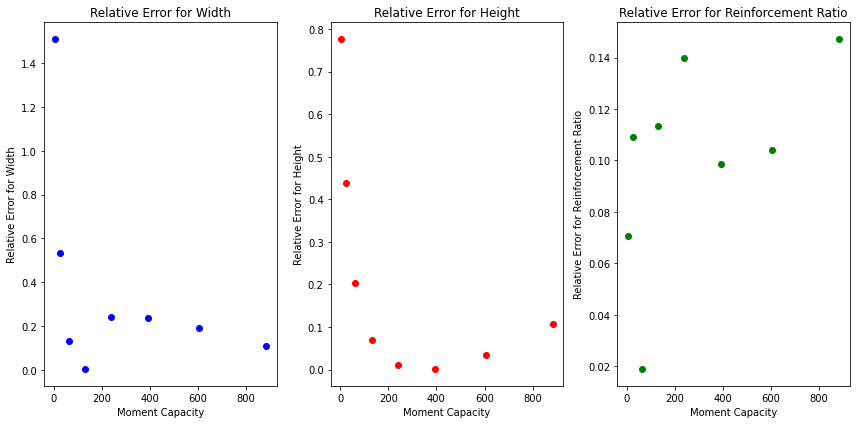

In [59]:

# Calculate the absolute errors for each predicted parameter
errors_width = np.abs(selected_actual_params[:, 0] - Designe_pred[:, 0])/selected_actual_params[:, 0]
errors_height = np.abs(selected_actual_params[:, 1] - Designe_pred[:, 1])/selected_actual_params[:, 1]
errors_reinforcement = np.abs(selected_actual_params[:, 2] - Designe_pred[:, 2])/selected_actual_params[:, 2]

# Plot the absolute errors for each predicted parameter
plt.figure(figsize=(12, 6))

# Width
plt.subplot(1, 3, 1)
plt.scatter(moment_capacity_test, errors_width, color='blue')
plt.xlabel('Moment Capacity')
plt.ylabel('Relative Error for Width')
plt.title('Relative Error for Width')

# Height
plt.subplot(1, 3, 2)
plt.scatter(moment_capacity_test, errors_height, color='red')
plt.xlabel('Moment Capacity')
plt.ylabel('Relative Error for Height')
plt.title('Relative Error for Height')

# Reinforcement ratio
plt.subplot(1, 3, 3)
plt.scatter(moment_capacity_test, errors_reinforcement, color='green')
plt.xlabel('Moment Capacity')
plt.ylabel('Relative Error for Reinforcement Ratio')
plt.title('Relative Error for Reinforcement Ratio')

plt.tight_layout()
plt.show()
